In [1]:
!pip install torch torchvision matplotlib scikit-image


In [2]:
import os, glob, random, shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import sobel
from google.colab import files


In [3]:
# Upload images
uploaded = files.upload()

# Train/test folders
train_dir = "/content/train_images"
test_dir = "/content/test_images"
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Split 80% train / 20% test
all_files = list(uploaded.keys())
random.shuffle(all_files)
split_idx = int(0.8 * len(all_files))
train_files = all_files[:split_idx]
test_files = all_files[split_idx:]

# Move files
for f in train_files: shutil.move(f"/content/{f}", os.path.join(train_dir, f))
for f in test_files: shutil.move(f"/content/{f}", os.path.join(test_dir, f))

print(f"✅ Training images: {len(train_files)}")
print(f"✅ Testing images: {len(test_files)}")


Saving IMG-20250924-WA0001.jpg to IMG-20250924-WA0001.jpg
Saving IMG-20250924-WA0002.jpg to IMG-20250924-WA0002.jpg
Saving IMG-20250924-WA0003.jpg to IMG-20250924-WA0003.jpg
Saving IMG-20250924-WA0004.jpg to IMG-20250924-WA0004.jpg
✅ Training images: 3
✅ Testing images: 1


In [5]:
# Step 4: Dataset Loader
class LunarDataset(Dataset):
    def __init__(self, folder, transform=None):
        # Collect all image files (png, jpeg, jpg)
        self.files = glob.glob(os.path.join(folder, "*.png")) + \
                     glob.glob(os.path.join(folder, "*.jpeg")) + \
                     glob.glob(os.path.join(folder, "*.jpg"))

        if len(self.files) == 0:
            raise ValueError(f"No images found in {folder}. Supported formats: png, jpeg, jpg.")

        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert("RGB")  # RGB for SRGAN
        hr = img.resize((256, 256), Image.BICUBIC)        # High-res (1m)
        lr = hr.resize((64, 64), Image.BICUBIC)          # Low-res (5m)
        lr = lr.resize((256, 256), Image.BICUBIC)        # Upscaled input

        if self.transform:
            hr = self.transform(hr)
            lr = self.transform(lr)
        return lr, hr

# Transform to tensor
transform = transforms.ToTensor()

# Create datasets
train_dataset = LunarDataset(train_dir, transform=transform)
test_dataset = LunarDataset(test_dir, transform=transform)

# Check lengths
print(f"✅ Train dataset size: {len(train_dataset)}")
print(f"✅ Test dataset size: {len(test_dataset)}")

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


✅ Train dataset size: 3
✅ Test dataset size: 1


In [6]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels),
            nn.PReLU(),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels)
        )
    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, scale_factor=4, num_residuals=16):
        super(Generator, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=9, padding=4), nn.PReLU())

        self.residual_blocks = nn.Sequential(*[ResidualBlock(64) for _ in range(num_residuals)])
        self.conv2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64))

        # Upsampling
        upsample_layers = []
        for _ in range(int(np.log2(scale_factor))):
            upsample_layers += [
                nn.Conv2d(64, 256, kernel_size=3, padding=1),
                nn.PixelShuffle(2),
                nn.PReLU()
            ]
        self.upsample = nn.Sequential(*upsample_layers)
        self.conv3 = nn.Conv2d(64, 3, kernel_size=9, padding=4)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.residual_blocks(x1)
        x2 = self.conv2(x2)
        x = x1 + x2
        x = self.upsample(x)
        x = self.conv3(x)
        return x


In [7]:
class Discriminator(nn.Module):
    def __init__(self, input_shape=(3, 256, 256)):
        super(Discriminator, self).__init__()
        in_channels, in_height, in_width = input_shape
        def block(in_ch, out_ch, stride):
            return [
                nn.Conv2d(in_ch, out_ch, 3, stride, 1),
                nn.BatchNorm2d(out_ch),
                nn.LeakyReLU(0.2, inplace=True)
            ]
        layers = [
            nn.Conv2d(in_channels, 64, 3, 1, 1),
            nn.LeakyReLU(0.2, inplace=True)
        ]
        layers += block(64, 64, 2)
        layers += block(64, 128, 1)
        layers += block(128, 128, 2)
        layers += block(128, 256, 1)
        layers += block(256, 256, 2)
        layers += block(256, 512, 1)
        layers += block(512, 512, 2)
        layers += [nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Linear(512, 1024), nn.LeakyReLU(0.2, inplace=True), nn.Linear(1024, 1), nn.Sigmoid()]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
generator = Generator().to(device)
discriminator = Discriminator().to(device)

criterion_GAN = nn.BCELoss()
criterion_content = nn.MSELoss()

optimizer_G = optim.Adam(generator.parameters(), lr=1e-4)
optimizer_D = optim.Adam(discriminator.parameters(), lr=1e-4)


In [10]:
# Step 8: Train SRGAN
epochs = 5

for epoch in range(epochs):
    generator.train()
    discriminator.train()

    for lr, hr in train_loader:
        lr, hr = lr.to(device), hr.to(device)

        # Create labels for GAN
        valid = torch.ones((lr.size(0), 1), device=device)
        fake = torch.zeros((lr.size(0), 1), device=device)

        # -----------------
        # 1️⃣ Train Generator
        # -----------------
        optimizer_G.zero_grad()
        sr = generator(lr)

        # Crop SR to HR size (in case of mismatch)
        min_h = min(sr.shape[2], hr.shape[2])
        min_w = min(sr.shape[3], hr.shape[3])
        sr = sr[:, :, :min_h, :min_w]
        hr_cropped = hr[:, :, :min_h, :min_w]

        # Content loss (MSE) + adversarial loss
        g_loss = criterion_content(sr, hr_cropped) + 1e-3 * criterion_GAN(discriminator(sr), valid)
        g_loss.backward()
        optimizer_G.step()

        # -----------------
        # 2️⃣ Train Discriminator
        # -----------------
        optimizer_D.zero_grad()
        real_loss = criterion_GAN(discriminator(hr_cropped), valid)
        fake_loss = criterion_GAN(discriminator(sr.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

    print(f"Epoch [{epoch+1}/{epochs}] | G Loss: {g_loss.item():.4f} | D Loss: {d_loss.item():.4f}")


Epoch [1/5] | G Loss: 0.0453 | D Loss: 0.6948
Epoch [2/5] | G Loss: 0.0883 | D Loss: 0.6915
Epoch [3/5] | G Loss: 0.0180 | D Loss: 0.6832
Epoch [4/5] | G Loss: 0.0175 | D Loss: 0.6828
Epoch [5/5] | G Loss: 0.0264 | D Loss: 0.6864


In [11]:
generator.eval()
os.makedirs("srgan_outputs", exist_ok=True)
with torch.no_grad():
    for i, (lr, hr) in enumerate(test_loader):
        lr = lr.to(device)
        sr = generator(lr).cpu().permute(0,2,3,1).squeeze().numpy()
        sr = np.clip(sr, 0, 1)
        plt.imsave(f"srgan_outputs/sr_{i}.png", sr)


In [12]:
def generate_hazard_map(image_path, save_path):
    img = Image.open(image_path).convert("L")
    img = np.array(img, dtype=np.float32)/255.0
    edges = sobel(img)
    plt.imsave(save_path, edges, cmap="hot")

for img_path in glob.glob("srgan_outputs/sr_*.png"):
    save_path = img_path.replace("sr_", "hazard_")
    generate_hazard_map(img_path, save_path)


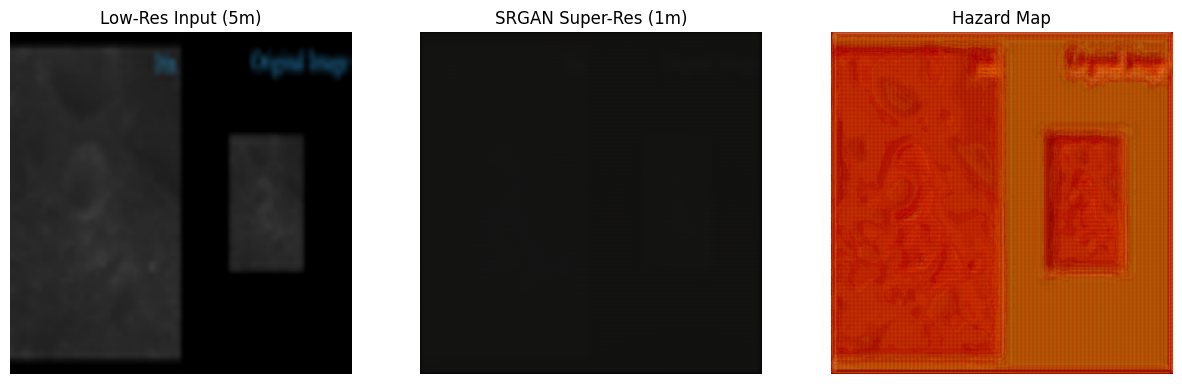

In [13]:
def visualize_results(lr_img, sr_img_path, hazard_img_path):
    lr_np = lr_img.squeeze().permute(1,2,0).numpy()
    sr_np = np.array(Image.open(sr_img_path).convert("RGB"))
    haz_np = np.array(Image.open(hazard_img_path).convert("L"))

    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1); plt.imshow(lr_np); plt.title("Low-Res Input (5m)"); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(sr_np); plt.title("SRGAN Super-Res (1m)"); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(haz_np, cmap="hot"); plt.title("Hazard Map"); plt.axis("off")
    plt.show()

# Example for first test image
test_iter = iter(test_loader)
lr, hr = next(test_iter)
sr_path = "srgan_outputs/sr_0.png"
haz_path = "srgan_outputs/hazard_0.png"
visualize_results(lr, sr_path, haz_path)
